## Testing ERA5 wind conversion ##

To verify that our models are doing the right thing, we want to verify that the conversion of ERA5 daily data to onshore and offshore wind capacity factors is doing something reasonable.

To do this we:

1) Pass 1 month of ERA5 data through CLEARHEADS model (hourly)
2) Verify this one month against CLEARHEADS Sim0 data (hourly?)
3) Pass 1 month of ERA5 data through CLEARHEADS model (daily)
4) Validate against CLEARHEADS Sim0 data and converted hourly data.

In [1]:
# Import local modules
import os
import sys
import time
import glob

# Import external modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# Import tqdm for progress bar
from tqdm import tqdm

In [2]:
# Specific import for the functions needed to create data
sys.path.append("/home/users/benhutch/unseen_functions/Hannah_CLEARHEADS/")
from functions_for_creating_NUTS_data import load_appropriate_mask, load_appropriate_data

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [3]:
# set up the path to the raw ERA5 hourly file
raw_ERA5_hourly_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_1hr_1950_01_DET.nc"
raw_ERA5_daily_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_1hr_1950_01_DET_daily_mean.nc"

# Set up the parameters
country = "United Kingdom"
nuts_level = 0
pop_weights = 0
sp_weights = 0
# wp_weights = 0 # for no location weighting
wp_weights = 1 # for location weighting
wp_sim = 0 # current distribution from thewindpower.net
ons_ofs = "ons" # verify onshore first (offshore worst)
field_str = "wp" # wind power
cc_flag = 0 # no climate change

# Set up the year and month
year = 1950
month = 1

In [4]:
# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=wp_weights,
    WP_sim=wp_sim,
    ons_ofs=ons_ofs,
    NUTS9_country_choice=country,
)

2020 wind farms
Using: /home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_ons_2021.nc
installed cap = 12.579789


In [5]:
# Print the country mask
print(country_mask)

[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]


In [6]:
# country mask max and min
print(country_mask.max(), country_mask.min())

0.67057 0.0


In [7]:
# Load the climate data and convert to a time series of area aggregated data
countr_agg_time_series = load_appropriate_data(
    field_str=field_str,
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs=ons_ofs,
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
)

In [8]:
print(countr_agg_time_series)

[0.18585838 0.20501603 0.23015401 0.26879155 0.29513977 0.32206685
 0.35766487 0.37800252 0.42172776 0.4392122  0.48674226 0.48332763
 0.49360984 0.50238882 0.50023773 0.5095564  0.49421712 0.47228246
 0.44020336 0.41994154 0.39547743 0.38460947 0.32363639 0.31788747
 0.29746766 0.29492397 0.30179379 0.30232255 0.2989642  0.30263754
 0.33332769 0.3515471  0.38545325 0.40424492 0.3418674  0.34765169
 0.32831309 0.33071579 0.32176689 0.31942154 0.30523531 0.29484189
 0.27736894 0.25665712 0.23505106 0.21734529 0.21637214 0.212432
 0.2013687  0.2030826  0.19919295 0.18599275 0.18226556 0.18456782
 0.18696485 0.20266734 0.22468157 0.25826677 0.32264459 0.38137645
 0.41724808 0.43116211 0.44332936 0.4249121  0.39034093 0.34195113
 0.30251945 0.30026167 0.31501984 0.34797811 0.31642633 0.35758467
 0.35576176 0.35147635 0.33387721 0.31634157 0.32064349 0.33523179
 0.36335113 0.38039057 0.38252395 0.38727777 0.40822356 0.41619215
 0.43356569 0.46754254 0.43443355 0.41905335 0.40159223 0.384622

In [9]:
# import the 'nc file using xarray
ERA5_hourly = xr.open_dataset(raw_ERA5_hourly_path)

# extract the time axis
time_axis = ERA5_hourly.time.values

In [10]:
# set up a dataframe with time_axis as the index (in datetime format)
ERA5_hourly_df = pd.DataFrame(index=pd.to_datetime(time_axis))

# # add a column for the wind speed at 100m
# u100 = ERA5_hourly.u100.values
# v100 = ERA5_hourly.v100.values
# speed_100 = np.sqrt(u100 ** 2 + v100 ** 2)

# # apply the mask to the wind speed data
# # where the mask is 1, keep the data, where the mask is 0, set the data to NaN
# country_mask[country_mask == 0] = np.nan

# # set up an empty array of zeros
# masked_speed_100 = np.zeros(speed_100.shape)

# # loop over the time axis
# for i in range(speed_100.shape[0]):
#     # apply the mask to the wind speed data
#     masked_speed_100[i, :, :] = speed_100[i, :, :] * country_mask

# # take the mean of the masked data over the 1st and 2nd dimensions
# ERA5_hourly_df["speed100m"] = np.nanmean(masked_speed_100, axis=(1, 2))

# # # add a column for the wind speed at 10m
# u10 = ERA5_hourly.u10.values
# v10 = ERA5_hourly.v10.values
# speed_10 = np.sqrt(u10 ** 2 + v10 ** 2)

# # # add a column for the wind direction at 100m
# masked_speed_10 = np.zeros(speed_10.shape)

# # # loop over the time axis
# for i in range(speed_10.shape[0]):
#     # apply the mask to the wind speed data
#     masked_speed_10[i, :, :] = speed_10[i, :, :] * country_mask

# # # take the mean of the masked data over the 1st and 2nd dimensions
# ERA5_hourly_df["speed10m"] = np.nanmean(masked_speed_10, axis=(1, 2))

# add a column for the onshore wind generation (GW)
ERA5_hourly_df["onshore_generation_cfs"] = countr_agg_time_series

In [11]:
ERA5_hourly_df.head()

,onshore_generation_cfs
1950-01-01 00:00:00,0.185858
1950-01-01 01:00:00,0.205016
1950-01-01 02:00:00,0.230154
1950-01-01 03:00:00,0.268792
1950-01-01 04:00:00,0.295140


In [12]:
# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=wp_weights,
    WP_sim=wp_sim,
    ons_ofs="ofs",
    NUTS9_country_choice=country,
)

2020 wind farms
Using: /home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_ofs_2021.nc
installed cap = 10.3218


In [13]:
# Same thing but offshore
countr_agg_time_series_of = load_appropriate_data(
    field_str=field_str,
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs="ofs",
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
)

In [14]:
# add this new column to the dataframe
ERA5_hourly_df["offshore_generation_cfs"] = countr_agg_time_series_of

In [15]:
ERA5_hourly_df.head()

,onshore_generation_cfs,offshore_generation_cfs
1950-01-01 00:00:00,0.185858,0.126081
1950-01-01 01:00:00,0.205016,0.132902
1950-01-01 02:00:00,0.230154,0.149275
1950-01-01 03:00:00,0.268792,0.163094
1950-01-01 04:00:00,0.295140,0.160107


In [16]:
# quantify the 100m wind speeds onshore
# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=0, # wind power weights
    WP_sim=wp_sim, 
    ons_ofs=ons_ofs,
    NUTS9_country_choice=country,
)

countr_agg_time_series_of_100m_winds = load_appropriate_data(
    field_str="speed100m",
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs=ons_ofs,
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
)

Found country


In [17]:
# add this new column to the dataframe
ERA5_hourly_df["ons_wind_speed_100m"] = countr_agg_time_series_of_100m_winds

In [18]:
ERA5_hourly_df.head()

,onshore_generation_cfs,offshore_generation_cfs,ons_wind_speed_100m
1950-01-01 00:00:00,0.185858,0.126081,5.208362
1950-01-01 01:00:00,0.205016,0.132902,5.309400
1950-01-01 02:00:00,0.230154,0.149275,5.385125
1950-01-01 03:00:00,0.268792,0.163094,5.516688
1950-01-01 04:00:00,0.295140,0.160107,5.581750


In [19]:
# same but offshore
# quantify the 100m wind speeds onshore
# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=0, # no wind power weights
    WP_sim=wp_sim, 
    ons_ofs="ofs",
    NUTS9_country_choice=country,
)

countr_agg_time_series_of_100m_winds = load_appropriate_data(
    field_str="speed100m",
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs="ofs",
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
)

Found country


In [20]:
# add the new column to the dataframe
ERA5_hourly_df["ofs_wind_speed_100m"] = countr_agg_time_series_of_100m_winds

In [21]:
ERA5_hourly_df.head()

,onshore_generation_cfs,offshore_generation_cfs,ons_wind_speed_100m,ofs_wind_speed_100m
1950-01-01 00:00:00,0.185858,0.126081,5.208362,5.404765
1950-01-01 01:00:00,0.205016,0.132902,5.309400,5.509613
1950-01-01 02:00:00,0.230154,0.149275,5.385125,5.588194
1950-01-01 03:00:00,0.268792,0.163094,5.516688,5.724718
1950-01-01 04:00:00,0.295140,0.160107,5.581750,5.792233


Text(0.5, 1.0, 'Onshore and Offshore Capacity Factors (hourly ERA5 conversion)')

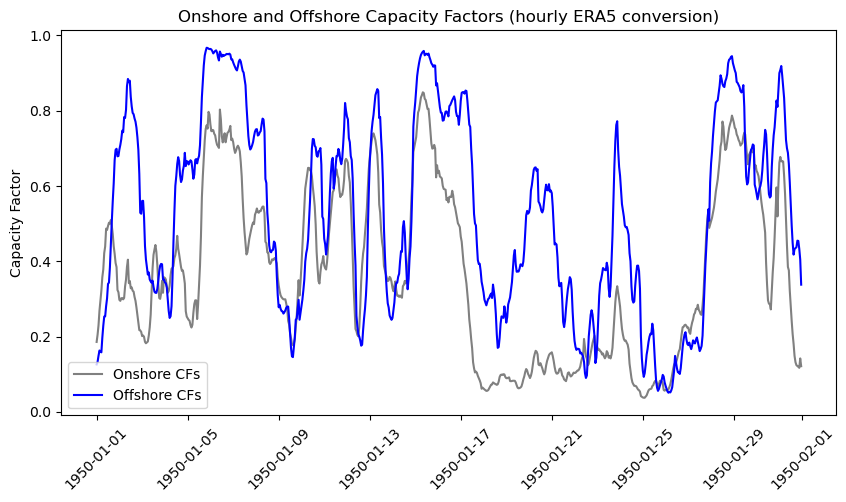

In [22]:
# plot the onshore generation cfs and offshore generation cfs
plt.figure(figsize=(10, 5))

plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")

# set the ylabel
plt.ylabel("Capacity Factor")

# include a legend
plt.legend()

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
plt.title("Onshore and Offshore Capacity Factors (hourly ERA5 conversion)")

Text(0.5, 1.0, 'Onshore and Offshore 100m Wind Speeds (hourly ERA5 conversion)')

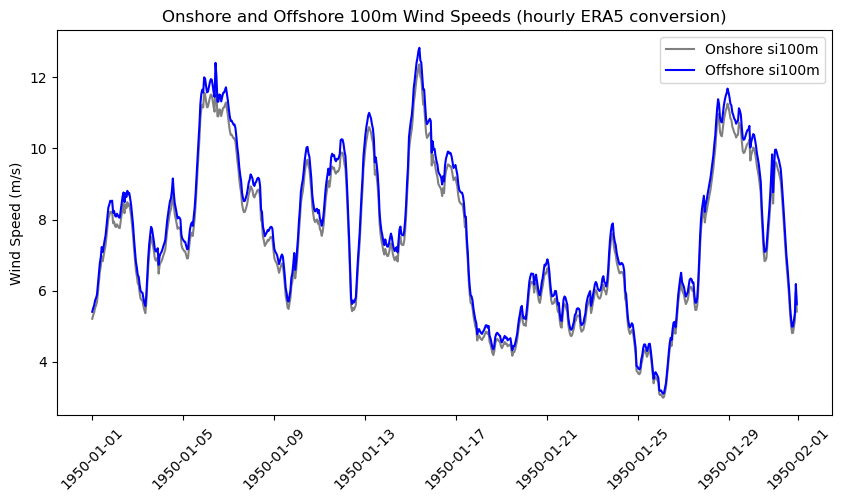

In [23]:
# plot the onshore generation cfs and offshore generation cfs
plt.figure(figsize=(10, 5))

plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["ons_wind_speed_100m"], label="Onshore si100m", color="gray")
plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["ofs_wind_speed_100m"], label="Offshore si100m", color="blue")

# set the ylabel
plt.ylabel("Wind Speed (m/s)")

# include a legend
plt.legend()

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
plt.title("Onshore and Offshore 100m Wind Speeds (hourly ERA5 conversion)")

In [24]:
# process the daily mean df
ERA5_daily_df = ERA5_hourly_df.resample("D").mean()

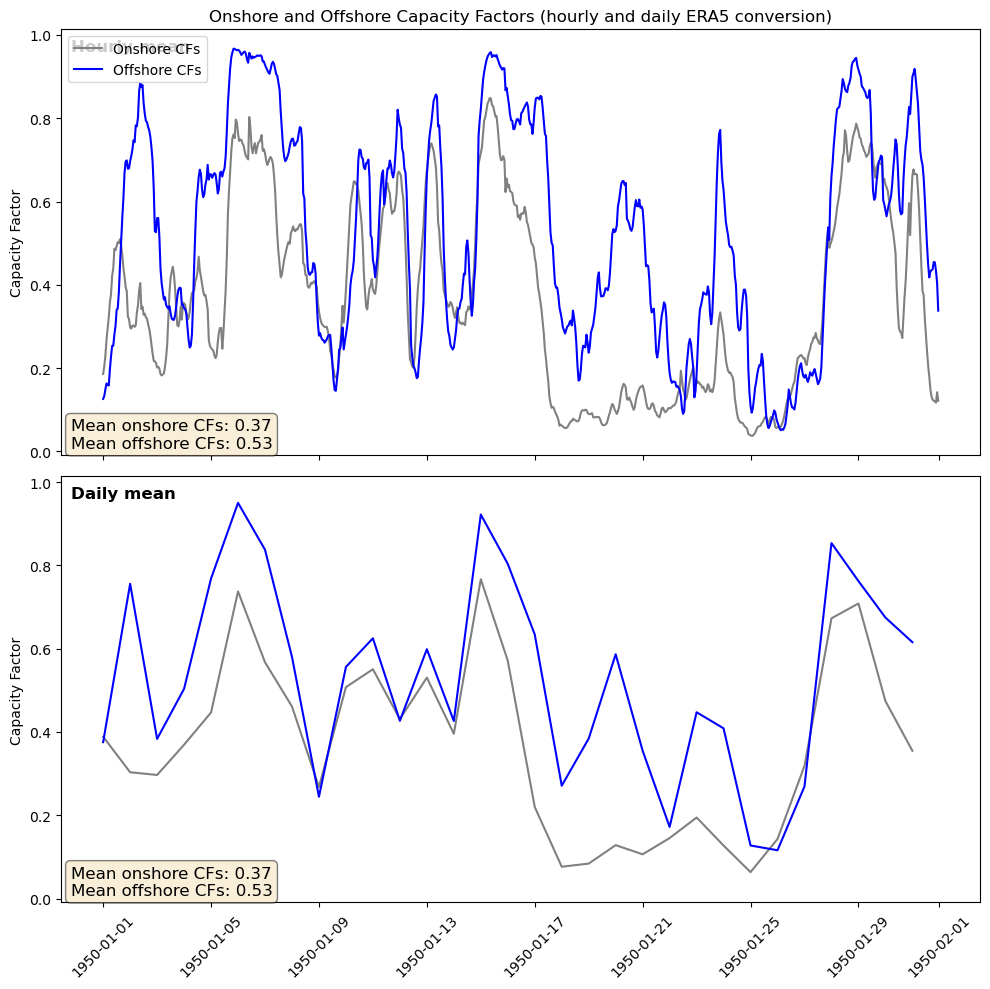

In [25]:
# subfigure with 1 column and 2 rows
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# plot the onshore generation cfs and offshore generation
axs[0].plot(ERA5_hourly_df.index, ERA5_hourly_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
axs[0].plot(ERA5_hourly_df.index, ERA5_hourly_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")

# set the ylabel
axs[0].set_ylabel("Capacity Factor")

# include a legend
axs[0].legend()

# Include text in the top left saying "Hourly"
axs[0].text(0.01, 0.95, "Hourly mean", transform=axs[0].transAxes, fontsize=12, fontweight="bold")

# inclue a textbox with the means
textstr = f"Mean onshore CFs: {ERA5_hourly_df['onshore_generation_cfs'].mean():.2f}\nMean offshore CFs: {ERA5_hourly_df['offshore_generation_cfs'].mean():.2f}"

# these are matplotlib.patch.Patch properties
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in lower left
axs[0].text(0.01, 0.01, textstr, transform=axs[0].transAxes, fontsize=12, verticalalignment="bottom", bbox=props)

# plot the onshore generation cfs and offshore generation
axs[1].plot(ERA5_daily_df.index, ERA5_daily_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
axs[1].plot(ERA5_daily_df.index, ERA5_daily_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")

# set the ylabel
axs[1].set_ylabel("Capacity Factor")

# include text in the top left saying "Daily"
axs[1].text(0.01, 0.95, "Daily mean", transform=axs[1].transAxes, fontsize=12, fontweight="bold")

# Set the same y-axis limits for both subplots
y_min = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
y_max = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim(y_min, y_max)
axs[1].set_ylim(y_min, y_max)

# include a textbox with the means
textstr = f"Mean onshore CFs: {ERA5_daily_df['onshore_generation_cfs'].mean():.2f}\nMean offshore CFs: {ERA5_daily_df['offshore_generation_cfs'].mean():.2f}"

# place a text box in lower left
axs[1].text(0.01, 0.01, textstr, transform=axs[1].transAxes, fontsize=12, verticalalignment="bottom", bbox=props)

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
axs[0].set_title("Onshore and Offshore Capacity Factors (hourly and daily ERA5 conversion)")

# set a tight layout
plt.tight_layout()

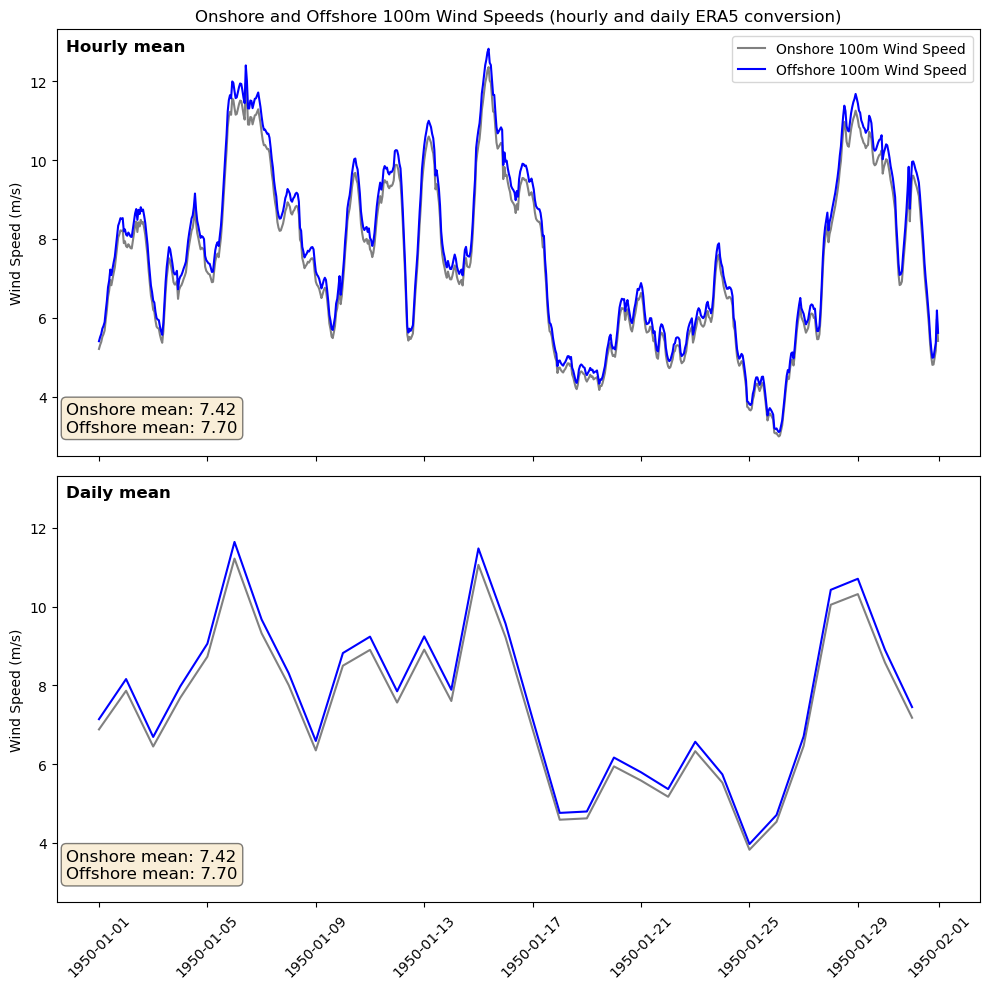

In [26]:
# subfigure with 1 column and 2 rows
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# plot the onshore wind speed and offshore wind speed
axs[0].plot(ERA5_hourly_df.index, ERA5_hourly_df["ons_wind_speed_100m"], label="Onshore 100m Wind Speed", color="gray")
axs[0].plot(ERA5_hourly_df.index, ERA5_hourly_df["ofs_wind_speed_100m"], label="Offshore 100m Wind Speed", color="blue")

# set the ylabel
axs[0].set_ylabel("Wind Speed (m/s)")

# include a legend
axs[0].legend()

# Include text in the top left saying "Hourly"
axs[0].text(0.01, 0.95, "Hourly mean", transform=axs[0].transAxes, fontsize=12, fontweight="bold")

# include a textbox with the means of both onshore and offshore
textstr = "Onshore mean: {:.2f}\nOffshore mean: {:.2f}".format(
    ERA5_hourly_df["ons_wind_speed_100m"].mean(), ERA5_hourly_df["ofs_wind_speed_100m"].mean()
)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in lower left in axes coords
axs[0].text(0.01, 0.05, textstr, transform=axs[0].transAxes, fontsize=12, verticalalignment="bottom", bbox=props)

# plot the onshore wind speed and offshore wind speed
axs[1].plot(ERA5_daily_df.index, ERA5_daily_df["ons_wind_speed_100m"], label="Onshore 100m Wind Speed", color="gray")
axs[1].plot(ERA5_daily_df.index, ERA5_daily_df["ofs_wind_speed_100m"], label="Offshore 100m Wind Speed", color="blue")

# set the ylabel
axs[1].set_ylabel("Wind Speed (m/s)")

# include text in the top left saying "Daily"
axs[1].text(0.01, 0.95, "Daily mean", transform=axs[1].transAxes, fontsize=12, fontweight="bold")

# include a textbox with the means of both onshore and offshore
textstr = "Onshore mean: {:.2f}\nOffshore mean: {:.2f}".format(
    ERA5_daily_df["ons_wind_speed_100m"].mean(), ERA5_daily_df["ofs_wind_speed_100m"].mean()
)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in lower left in axes coords
axs[1].text(0.01, 0.05, textstr, transform=axs[1].transAxes, fontsize=12, verticalalignment="bottom", bbox=props)

# Set the same y-axis limits for both subplots
y_min = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
y_max = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim(y_min, y_max)
axs[1].set_ylim(y_min, y_max)

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# include a title
axs[0].set_title("Onshore and Offshore 100m Wind Speeds (hourly and daily ERA5 conversion)")

# set a tight layout
plt.tight_layout()

### Same processing - now with daily data ###

With the same data aggregated into daily means, how different are the results.

In [27]:
# set up the path to the raw ERA5 hourly file
raw_ERA5_hourly_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_1hr_1950_01_DET.nc"
raw_ERA5_daily_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_daily_1950_01.nc"

# Set up the parameters
country = "United Kingdom"
nuts_level = 0
pop_weights = 0
sp_weights = 0
# wp_weights = 0 # for no location weighting
wp_weights = 1 # for location weighting
wp_sim = 0 # current distribution from thewindpower.net
ons_ofs = "ons" # verify onshore first (offshore worst)
field_str = "wp" # wind power
cc_flag = 0 # no climate change

# Set up the year and month
year = 1950
month = 1

In [28]:
# Load the weighted country mask for wind CFs
# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=wp_weights,
    WP_sim=wp_sim,
    ons_ofs=ons_ofs,
    NUTS9_country_choice=country,
)

# Load the DAILY climate data and convert to a time series of area aggregated data
countr_agg_time_series = load_appropriate_data(
    field_str=field_str,
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs=ons_ofs,
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
    daily_flag=True,
)

2020 wind farms
Using: /home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_ons_2021.nc
installed cap = 12.579789


In [29]:
# Open the daily data
ERA5_daily = xr.open_dataset(raw_ERA5_daily_path)

# extract the time axis
time_axis = ERA5_daily.time.values

# set up a dataframe with time_axis as the index (in datetime format)
ERA5_daily_ERA5_df = pd.DataFrame(index=pd.to_datetime(time_axis))

In [30]:
# add a column for the onshore wind Cfs
ERA5_daily_ERA5_df["onshore_generation_cfs"] = countr_agg_time_series

In [31]:
# Now do the same but for offshore wind speeds
ons_ofs = "ofs"

# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=wp_weights,
    WP_sim=wp_sim,
    ons_ofs=ons_ofs,
    NUTS9_country_choice=country,
)

# Load the DAILY climate data and convert to a time series of area aggregated data
countr_agg_time_series = load_appropriate_data(
    field_str=field_str,
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs=ons_ofs,
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
    daily_flag=True,
)

2020 wind farms
Using: /home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_ofs_2021.nc
installed cap = 10.3218


In [32]:
# add a column for the offshore wind Cfs
ERA5_daily_ERA5_df["offshore_generation_cfs"] = countr_agg_time_series

In [33]:
# # quantify the offshore 100m wind speeds from daily data
wp_weights = 0 # no wind power weights
field_str = "speed100m"

# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=wp_weights,
    WP_sim=wp_sim,
    ons_ofs=ons_ofs,
    NUTS9_country_choice=country,
)

# Load the DAILY climate data and convert to a time series of area aggregated data
countr_agg_time_series = load_appropriate_data(
    field_str=field_str,
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs=ons_ofs,
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
    daily_flag=True,
)

Found country


/home/users/benhutch/unseen_functions/Hannah_CLEARHEADS/functions_for_creating_NUTS_data.py:1242: RuntimeWarning: Mean of empty slice
  country_agg = np.nanmean(np.nanmean(data, axis=2), axis=1)


In [34]:
# add a new column for the offshore 100m wind speeds
ERA5_daily_ERA5_df["ofs_wind_speed_100m"] = countr_agg_time_series

In [35]:
# now do the same but for onshore
ons_ofs = "ons"

# Load the appropriate mask for the UK
country_mask = load_appropriate_mask(
    COUNTRY=country,
    NUTS_lev=nuts_level,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    wp_weights=wp_weights,
    WP_sim=wp_sim,
    ons_ofs=ons_ofs,
    NUTS9_country_choice=country,
)

# Load the DAILY climate data and convert to a time series of area aggregated data
countr_agg_time_series = load_appropriate_data(
    field_str=field_str,
    year=year,
    month=month,
    country_mask=country_mask,
    ons_ofs=ons_ofs,
    wp_weights=wp_weights,
    pop_weights=pop_weights,
    sp_weights=sp_weights,
    NUTS_lev=nuts_level,
    CC_flag=cc_flag,
    MODEL_NAME="ERA5",
    daily_flag=True,
)

Found country


/home/users/benhutch/unseen_functions/Hannah_CLEARHEADS/functions_for_creating_NUTS_data.py:1242: RuntimeWarning: Mean of empty slice
  country_agg = np.nanmean(np.nanmean(data, axis=2), axis=1)


In [36]:
# add a new column for the onshore 100m wind speeds
ERA5_daily_ERA5_df["ons_wind_speed_100m"] = countr_agg_time_series

In [37]:
# head of the dataframe
ERA5_daily_ERA5_df.head()

,onshore_generation_cfs,offshore_generation_cfs,ofs_wind_speed_100m,ons_wind_speed_100m
1950-01-01 11:00:00,0.333588,0.317195,7.085801,6.828311
1950-01-02 11:00:00,0.261036,0.735320,7.970046,7.680424
1950-01-03 11:00:00,0.233287,0.340410,5.421050,5.224056
1950-01-04 11:00:00,0.321469,0.354755,7.092586,6.834850
1950-01-05 11:00:00,0.350297,0.765987,8.339486,8.036439


Text(0.5, 1.0, 'Onshore and Offshore Capacity Factors (daily ERA5 conversion)')

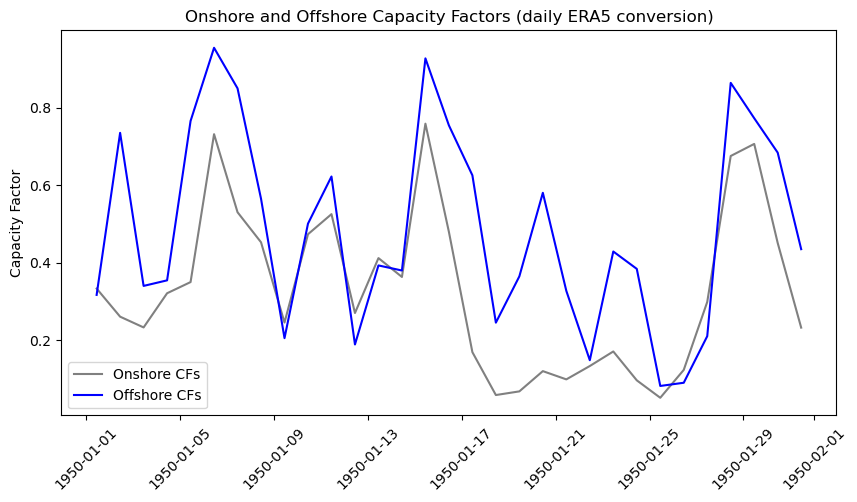

In [38]:
# plot the onshore generation cfs and offshore generation cfs
plt.figure(figsize=(10, 5))

plt.plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
plt.plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")

# set the ylabel
plt.ylabel("Capacity Factor")

# include a legend
plt.legend()

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
plt.title("Onshore and Offshore Capacity Factors (daily ERA5 conversion)")

Text(0.5, 1.0, 'Onshore and Offshore 100m Wind Speeds (daily ERA5 conversion)')

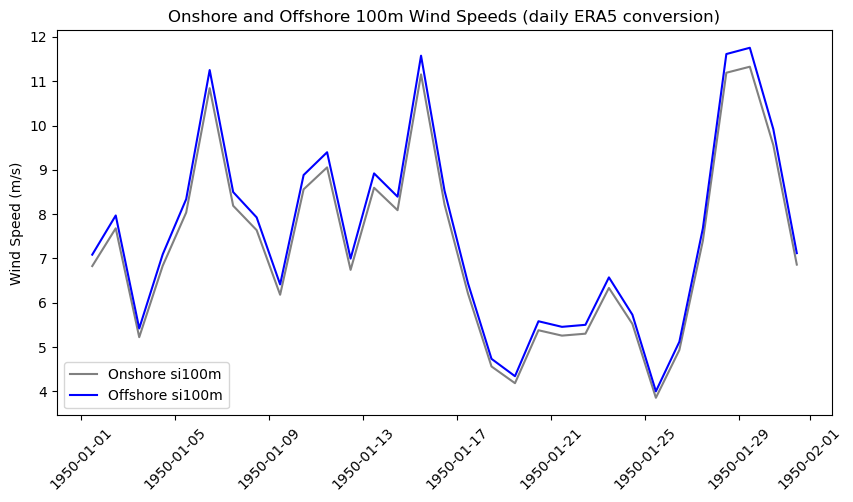

In [39]:
# plot the onshore generation cfs and offshore generation cfs
plt.figure(figsize=(10, 5))

plt.plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["ons_wind_speed_100m"], label="Onshore si100m", color="gray")
plt.plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["ofs_wind_speed_100m"], label="Offshore si100m", color="blue")

# set the ylabel
plt.ylabel("Wind Speed (m/s)")

# include a legend
plt.legend()

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
plt.title("Onshore and Offshore 100m Wind Speeds (daily ERA5 conversion)")

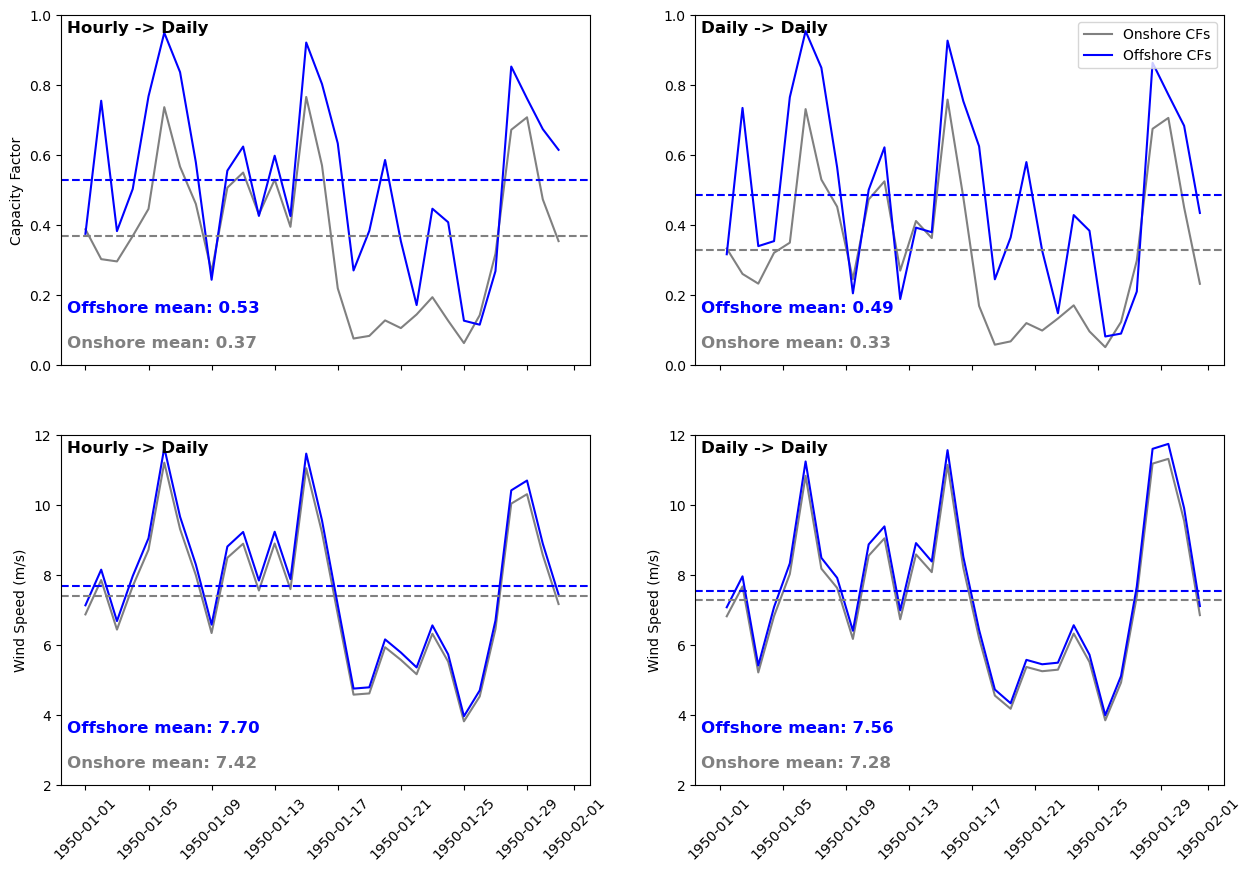

In [40]:
# figure with 4 subplots
# 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)

# set the ylmis for the cfs
ylim_cfs = [0, 1]

# set the ylims for the wind speeds
ylim_wind = [2, 12]

# plot the onshore generation cfs and offshore generation
# for the ERA5_daily_df
axs[0][0].plot(ERA5_daily_df.index, ERA5_daily_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
axs[0][0].plot(ERA5_daily_df.index, ERA5_daily_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")

# plot the means as a horizontal line
axs[0][0].axhline(ERA5_daily_df["onshore_generation_cfs"].mean(), color="gray", linestyle="--")
axs[0][0].axhline(ERA5_daily_df["offshore_generation_cfs"].mean(), color="blue", linestyle="--")

# include the values on the lines
axs[0][0].text(0.01, 0.05, f"Onshore mean: {ERA5_daily_df['onshore_generation_cfs'].mean():.2f}", transform=axs[0][0].transAxes, fontsize=12, fontweight="bold", color="gray")
axs[0][0].text(0.01, 0.15, f"Offshore mean: {ERA5_daily_df['offshore_generation_cfs'].mean():.2f}", transform=axs[0][0].transAxes, fontsize=12, fontweight="bold", color="blue")

# set the ylims
axs[0][0].set_ylim(ylim_cfs)

# set the ylabel
axs[0][0].set_ylabel("Capacity Factor")

# Include text in the top left saying "Hourly -> Daily"
axs[0][0].text(0.01, 0.95, "Hourly -> Daily", transform=axs[0][0].transAxes, fontsize=12, fontweight="bold")

# plot the onshore generation cfs and offshore generation
# for the ERA5_daily_ERA5_df
axs[0][1].plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
axs[0][1].plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")

# plot the means as a horizontal line
axs[0][1].axhline(ERA5_daily_ERA5_df["onshore_generation_cfs"].mean(), color="gray", linestyle="--")
axs[0][1].axhline(ERA5_daily_ERA5_df["offshore_generation_cfs"].mean(), color="blue", linestyle="--")

# set the ylims
axs[0][1].set_ylim(ylim_cfs)

# include the values on the lines
axs[0][1].text(0.01, 0.05, f"Onshore mean: {ERA5_daily_ERA5_df['onshore_generation_cfs'].mean():.2f}", transform=axs[0][1].transAxes, fontsize=12, fontweight="bold", color="gray")
axs[0][1].text(0.01, 0.15, f"Offshore mean: {ERA5_daily_ERA5_df['offshore_generation_cfs'].mean():.2f}", transform=axs[0][1].transAxes, fontsize=12, fontweight="bold", color="blue")

# Set text in the top left saying "Daily -> Daily"
axs[0][1].text(0.01, 0.95, "Daily -> Daily", transform=axs[0][1].transAxes, fontsize=12, fontweight="bold")

# include a legend
axs[0][1].legend(loc="upper right")

# plot the onshore wind speed and offshore wind speed
# for the ERA5_daily_df
axs[1][0].plot(ERA5_daily_df.index, ERA5_daily_df["ons_wind_speed_100m"], label="Onshore 100m Wind Speed", color="gray")
axs[1][0].plot(ERA5_daily_df.index, ERA5_daily_df["ofs_wind_speed_100m"], label="Offshore 100m Wind Speed", color="blue")

# plot the means as a horizontal line
axs[1][0].axhline(ERA5_daily_df["ons_wind_speed_100m"].mean(), color="gray", linestyle="--")
axs[1][0].axhline(ERA5_daily_df["ofs_wind_speed_100m"].mean(), color="blue", linestyle="--")

# Set the ylmis
axs[1][0].set_ylim(ylim_wind)

# include the values on the lines
axs[1][0].text(0.01, 0.05, f"Onshore mean: {ERA5_daily_df['ons_wind_speed_100m'].mean():.2f}", transform=axs[1][0].transAxes, fontsize=12, fontweight="bold", color="gray")
axs[1][0].text(0.01, 0.15, f"Offshore mean: {ERA5_daily_df['ofs_wind_speed_100m'].mean():.2f}", transform=axs[1][0].transAxes, fontsize=12, fontweight="bold", color="blue")

# set the ylabel
axs[1][0].set_ylabel("Wind Speed (m/s)")

# Include text in the top left saying "Hourly -> Daily"
axs[1][0].text(0.01, 0.95, "Hourly -> Daily", transform=axs[1][0].transAxes, fontsize=12, fontweight="bold")

# plot the onshore wind speed and offshore wind speed
# for the ERA5_daily_ERA5_df
axs[1][1].plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["ons_wind_speed_100m"], label="Onshore 100m Wind Speed", color="gray")
axs[1][1].plot(ERA5_daily_ERA5_df.index, ERA5_daily_ERA5_df["ofs_wind_speed_100m"], label="Offshore 100m Wind Speed", color="blue")

# plot the means as a horizontal line
axs[1][1].axhline(ERA5_daily_ERA5_df["ons_wind_speed_100m"].mean(), color="gray", linestyle="--")
axs[1][1].axhline(ERA5_daily_ERA5_df["ofs_wind_speed_100m"].mean(), color="blue", linestyle="--")

# include the values on the lines
axs[1][1].text(0.01, 0.05, f"Onshore mean: {ERA5_daily_ERA5_df['ons_wind_speed_100m'].mean():.2f}", transform=axs[1][1].transAxes, fontsize=12, fontweight="bold", color="gray")
axs[1][1].text(0.01, 0.15, f"Offshore mean: {ERA5_daily_ERA5_df['ofs_wind_speed_100m'].mean():.2f}", transform=axs[1][1].transAxes, fontsize=12, fontweight="bold", color="blue")

# set the ylims
axs[1][1].set_ylim(ylim_wind)

# set the ylabel
axs[1][1].set_ylabel("Wind Speed (m/s)")

# Include text in the top left saying "Daily -> Daily"
axs[1][1].text(0.01, 0.95, "Daily -> Daily", transform=axs[1][1].transAxes, fontsize=12, fontweight="bold")

# tilt the xlabels by 45 degrees
axs[1][0].tick_params(axis="x", rotation=45)
axs[1][1].tick_params(axis="x", rotation=45)


Now verify against actual CLEARHEADS data. Should be the same, right?

In [41]:
# Define the directory in which the data are stored
clearheads_dir = "/home/users/benhutch/CLEARHEADS_EU_Power_Data"

# Define the file name for weather dependent demand
# first list all of the files in the directory
clearheads_files = os.listdir(clearheads_dir)

# print out the files
clearheads_files

['EEZ_zones_wp_historical.nc',
 'NUTS_0_CDD_historical_pop_weighted.nc',
 'NUTS_0_HDD_historical_pop_weighted.nc',
 'NUTS_0_sp_historical.nc',
 'NUTS_0_sp_historical_loc_weighted.nc',
 'NUTS_0_speed100m_historical.nc',
 'NUTS_0_speed10m_historical.nc',
 'NUTS_0_speed10m_historical_pop_weighted.nc',
 'NUTS_0_ssrd_historical.nc',
 'NUTS_0_ssrd_historical_pop_weighted.nc',
 'NUTS_0_t2m_detrended_timeseries_historical.nc',
 'NUTS_0_t2m_detrended_timeseries_historical_pop_weighted.nc',
 'NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc',
 'NUTS_1_sp_historical.nc',
 'NUTS_1_speed100m_historical.nc',
 'NUTS_1_speed10m_historical.nc',
 'NUTS_1_ssrd_historical.nc',
 'NUTS_1_t2m_detrended_timeseries_historical.nc',
 'NUTS_1_wp_historical.nc',
 'NUTS_2_sp_historical.nc',
 'NUTS_2_speed100m_historical.nc',
 'NUTS_2_speed10m_historical.nc',
 'NUTS_2

In [42]:
# create the list of files to extract
ch_ofs_sim0_fname = "NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc"
ch_ons_sim0_fname = "NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc"
ch_ons_wind_100m_fname = "NUTS_0_speed100m_historical.nc"

# create the list
ch_files = [ch_ofs_sim0_fname, ch_ons_sim0_fname, ch_ons_wind_100m_fname]

In [43]:
df_list = []

# loop over the files list
for file in ch_files:
    # create the path to the file
    file_path = os.path.join(clearheads_dir, file)

    # assert that the file exists
    assert os.path.exists(file_path), f"File {file_path} does not exist"

    # open the file
    ch_ds = xr.open_dataset(file_path)

    # assert "NUTS_keys" is in the variables
    assert "NUTS_keys" in ch_ds.variables, f"NUTS_keys not in {file_path}"

    # extract the NUTS keys
    NUTS_keys = ch_ds["NUTS_keys"].values

    # turn the data into a dataframe
    ch_df = ch_ds.to_dataframe()

    # pivot the dataframe
    ch_df = ch_df.reset_index().pivot(
        index="time_in_hours_from_first_jan_1950",
        columns="NUTS",
        values="timeseries_data",
    )

    # set the columns as the NUTS keys
    ch_df.columns = NUTS_keys

    # Convert 'time_in_hours_from_first_jan_1950' column to datetime
    ch_df.index = pd.to_datetime(ch_df.index, unit="h", origin="1950-01-01")

    # append the dataframe to the list
    df_list.append(ch_df)

In [44]:
# set up an empty df with the index as the time axis of the first dataframe
combined_df = pd.DataFrame(index=df_list[0].index)

# add a column for the ofs_sim0_wind_cfs
combined_df["ofs_sim0_wind_cfs"] = df_list[0]["UK"]

# add a column for the ons_sim0_wind_cfs
combined_df["ons_sim0_wind_cfs"] = df_list[1]["UK"]

# add a column for the ons_wind_100m
combined_df["ons_wind_100m"] = df_list[2]["UK"]

In [45]:
combined_df.head()

,ofs_sim0_wind_cfs,ons_sim0_wind_cfs,ons_wind_100m
time_in_hours_from_first_jan_1950,,,
1950-01-01 00:00:00,0.126081,0.150885,6.148996
1950-01-01 01:00:00,0.132902,0.169805,6.156016
1950-01-01 02:00:00,0.149275,0.195890,6.138777
1950-01-01 03:00:00,0.163094,0.235261,6.390699
1950-01-01 04:00:00,0.160107,0.261474,6.461800


In [46]:
# limit combined df to between 1950-01-01 and 1950-01-31
combined_df = combined_df.loc["1960-11-01":"1960-11-30"]

In [47]:
# # verify the winds first
# plt.figure(figsize=(10, 5))

# plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["ons_wind_speed_100m"], label="ERA5 100m Onshore", color="gray")
# # plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["ofs_wind_speed_100m"], label="ERA5 100m Offshore", color="blue")
# plt.plot(combined_df.index, combined_df["ons_wind_100m"], label="CLEARHEADS 100m Onshore", color="gray", linestyle="--")

# # set the ylabel
# plt.ylabel("Wind Speed (m/s)")

# # include a legend
# plt.legend()

# # tilt the xlabels by 45 degrees
# plt.xticks(rotation=45)

# # inclue a title
# plt.title("Onshore and Offshore 100m Wind Speeds (ERA5 vs CLEARHEADS)")

Looks pretty similar, but not the same - close enough?

Text(0.5, 1.0, 'Onshore and Offshore Capacity Factors (hourly ERA5 conversion) CLEARHEADS comparison')

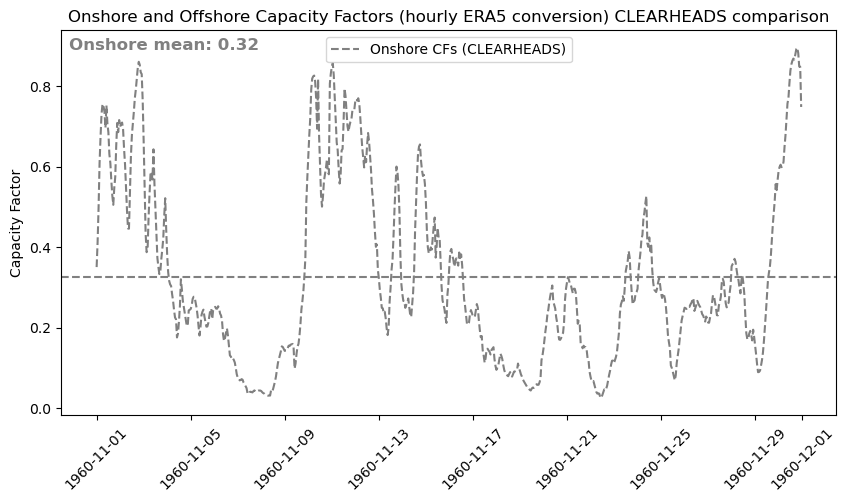

In [53]:
# verify against my hourly data
# plot the onshore generation cfs and offshore generation cfs
plt.figure(figsize=(10, 5))

# plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
plt.plot(combined_df.index, combined_df["ons_sim0_wind_cfs"], label="Onshore CFs (CLEARHEADS)", color="gray", linestyle="--")
# plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")
# plt.plot(combined_df.index, combined_df["ofs_sim0_wind_cfs"], label="Offshore CFs (CLEARHEADS)", color="blue", linestyle="--")

# plot the means as a horizontal line
# plt.axhline(ERA5_hourly_df["onshore_generation_cfs"].mean(), color="gray", linestyle="--")
plt.axhline(combined_df["ons_sim0_wind_cfs"].mean(), color="gray", linestyle="--")
# plt.axhline(combined_df["ofs_sim0_wind_cfs"].mean(), color="blue", linestyle="--")


# include the mean in a textbox in the top left
# plt.text(0.01, 0.95, f"Onshore mean: {ERA5_hourly_df['onshore_generation_cfs'].mean():.2f}", transform=plt.gca().transAxes, fontsize=12, fontweight="bold", color="gray")
plt.text(0.01, 0.95, f"Onshore mean: {combined_df['ons_sim0_wind_cfs'].mean():.2f}", transform=plt.gca().transAxes, fontsize=12, fontweight="bold", color="gray")
# plt.text(0.01, 0.95, f"Offshore mean: {combined_df['ofs_sim0_wind_cfs'].mean():.2f}", transform=plt.gca().transAxes, fontsize=12, fontweight="bold", color="blue")


# set the ylabel
plt.ylabel("Capacity Factor")

# include a legend
plt.legend()

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
plt.title("Onshore and Offshore Capacity Factors (hourly ERA5 conversion) CLEARHEADS comparison")

Onshore looks fine...

Text(0.5, 1.0, 'Onshore and Offshore Capacity Factors (hourly ERA5 conversion) CLEARHEADS comparison')

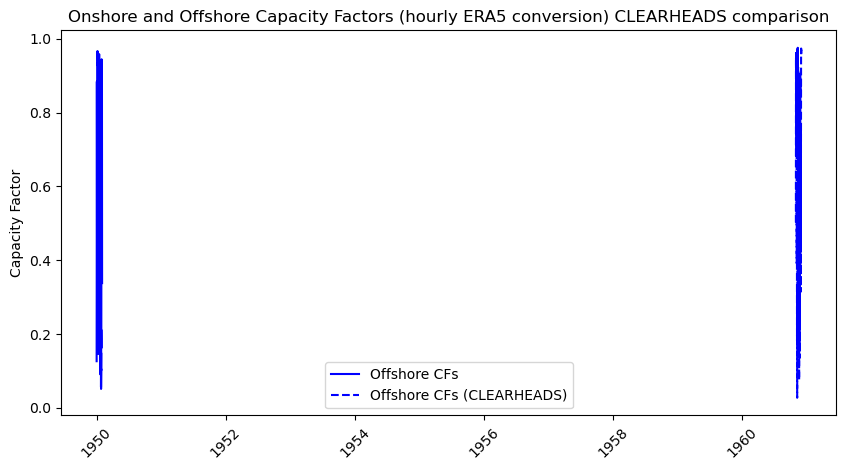

In [49]:
# verify against my hourly data
# plot the onshore generation cfs and offshore generation cfs
plt.figure(figsize=(10, 5))

# plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["onshore_generation_cfs"], label="Onshore CFs", color="gray")
# plt.plot(combined_df.index, combined_df["ons_sim0_wind_cfs"], label="Onshore CFs (CLEARHEADS)", color="gray", linestyle="--")
plt.plot(ERA5_hourly_df.index, ERA5_hourly_df["offshore_generation_cfs"], label="Offshore CFs", color="blue")
plt.plot(combined_df.index, combined_df["ofs_sim0_wind_cfs"], label="Offshore CFs (CLEARHEADS)", color="blue", linestyle="--")

# set the ylabel
plt.ylabel("Capacity Factor")

# include a legend
plt.legend()

# tilt the xlabels by 45 degrees
plt.xticks(rotation=45)

# inclue a title
plt.title("Onshore and Offshore Capacity Factors (hourly ERA5 conversion) CLEARHEADS comparison")

Offshore looks good.

If we now assume that our time series are equal to the clearheads time series, then the daily conversion doesn't really work.